In [1]:
# For now we use the embeddings of what a group member said to predict/his her gratitude rating for a session
# One improvement could be to compute the average embedding of what other group members said during the session
# and concatenate this vector with the vector representing the individual's utterances.  A classifier trained on
# individual features + group features should perform a bit better with enough data

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gc
import multiprocessing
from datasets import load_from_disk, Dataset, DatasetDict  
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

from embed import mean_pool_sentence_embedding

In [3]:
max_seq_len = 512
data_path = 'transcript_data.xlsx'
ids_path = 'ids.xlsx'
ratings_path = 'gratitude.xlsx'
lm_path = 'roberta-base'

# Set the batch size for the embedding model
batch_size = 16

# Select whether to compute new embeddings for the data or use precomputed embeddings
# On the first run, embeddings must be computed.  On subsequent runs, embeddings can be loaded from disk.
embed = True

# Set the device to GPU if you have one, MPS if you are on a Mac with an M1/M2 chip, otherwise CPU
device = "cuda:0"

seed = 44
k = 5


# COMPARE BERT-BASED Features to TFIDF

In [4]:
torch.__version__

'1.8.1+cu101'

In [5]:
rating_df = pd.read_excel(ratings_path)

In [6]:
rating_df.head()

,DigitID,Group,Session,Gratitude_Group,Gratitude_Members,Gratitude_Leaders
0,638,2,1,7.0,8.0,8.0
1,638,2,2,7.0,7.0,7.0
2,638,2,3,8.0,8.0,8.0
3,638,2,4,8.0,8.0,8.0
4,638,2,5,8.0,8.0,8.0


In [7]:
id_df = pd.read_excel(ids_path)

In [8]:
id_df.head()

,Group,Digit ID,Member ID
0,2,6575.0,M7
1,2,4795.0,M2
2,2,8592.0,M5
3,2,1274.0,M1
4,2,NaN,NaN


In [9]:
digit_rating_df = pd.merge(
    rating_df[['DigitID', 'Group', 'Session', 'Gratitude_Members']],
    id_df,
    how='inner',
    left_on='DigitID',
    right_on='Digit ID'
).drop_duplicates().drop('Group_y', axis=1).rename(columns={'Group_x': 'Group'})

In [10]:
digit_rating_df.head()

,DigitID,Group,Session,Gratitude_Members,Digit ID,Member ID
0,638,2,1,8.0,638.0,M4
1,638,2,2,7.0,638.0,M4
2,638,2,3,8.0,638.0,M4
3,638,2,4,8.0,638.0,M4
4,638,2,5,8.0,638.0,M4


In [11]:
df = pd.read_excel(data_path)

In [12]:
df.head()

,Member ID,Group,Session,Utterance
0,L1,2.0,1.0,"OK, I think you should receive a notification ..."
1,M1,2.0,1.0,Who would you like to go first?
2,L1,2.0,1.0,Whoever wanted to go first.
3,M1,2.0,1.0,I can go sometime. I'm muted. I'm M1. I live i...
4,L1,2.0,1.0,"Oh, OK. I think someone put in the chat. Let m..."


In [13]:
df = pd.merge(
    df,
    digit_rating_df,
    how='inner',
    on=['Member ID', 'Group', 'Session']
)

In [14]:
df.head()

,Member ID,Group,Session,Utterance,DigitID,Gratitude_Members,Digit ID
0,M2,2.0,1.0,"Go next. Hi, M5. I am also at the same Element...",4795,8.0,4795.0
1,M2,2.0,1.0,It's interesting because it was one of those t...,4795,8.0,4795.0
2,M2,2.0,1.0,Thank you. Thanks for having me.,4795,8.0,4795.0
3,M2,2.0,1.0,"I mean, M5, like, you know that already, right...",4795,8.0,4795.0
4,M2,2.0,1.0,"I know M5 pretty well, so I I feel fine as long.",4795,8.0,4795.0


In [15]:
grouped_df = df.groupby(['Group', 'Session', 'Member ID']).agg({'Gratitude_Members': 'max'}).reset_index()

In [16]:
grouped_df

,Group,Session,Member ID,Gratitude_Members
0,2.0,1.0,M2,8.0
1,2.0,1.0,M4,8.0
2,2.0,2.0,M2,9.0
3,2.0,2.0,M3,10.0
4,2.0,2.0,M4,7.0
...,...,...,...,...
58,6.0,3.0,M81,10.0
59,6.0,3.0,M83,8.0
60,6.0,3.0,M85,10.0
61,6.0,3.0,M86,10.0


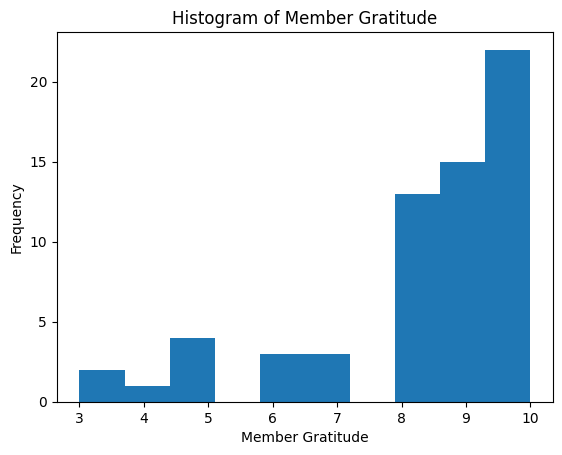

In [17]:
plt.hist(grouped_df['Gratitude_Members'], bins=10)
plt.xlabel('Member Gratitude')
plt.ylabel('Frequency')
plt.title("Histogram of Member Gratitude")
plt.show()

In [18]:
tokenizer = AutoTokenizer.from_pretrained(lm_path)

In [19]:
def plot_token_len_distribution(dataset):

    plt.hist([len(ids) for ids in dataset['input_ids']], bins=50)
    plt.ylabel("Frequency")
    plt.xlabel("Tokens per Utterance")
    plt.title("Distribution of Tokens per Utterance")
    plt.show()

In [20]:
def tokenize_text(record, tokenizer, truncate_to):
    
    return {
        'input_ids': tokenizer(
            record['text'],
            padding=False,
            truncation=True,
            max_length=truncate_to
        )['input_ids']
    }

In [21]:
def tokenize_plot(dataset, tokenizer, truncate_to, batch_size=512, proc_div=2):
    
    num_proc = int(multiprocessing.cpu_count() / proc_div)
    print(f"Tokenizing with {num_proc} CPU processes...")
    
    dataset = dataset.map(
        tokenize_text,
        batched=True,
        batch_size=batch_size,
        fn_kwargs={
            "tokenizer": tokenizer,
            "truncate_to": truncate_to
        },
        num_proc=num_proc
    )
    
    plot_token_len_distribution(dataset)
    dataset.remove_columns('input_ids')
    gc.collect()

Tokenizing with 4 CPU processes...


Map (num_proc=4):   0%|          | 0/433 [00:00<?, ? examples/s]

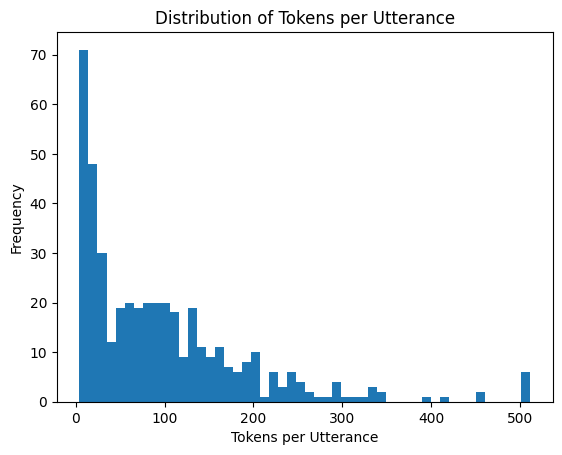

In [22]:
text_df = df.rename(columns={'Utterance': 'text'})[['Group', 'Session', 'Member ID', 'text', 'Gratitude_Members']]
tokenize_plot(Dataset.from_pandas(text_df), tokenizer, truncate_to=max_seq_len)

In [23]:
text_df.head()

,Group,Session,Member ID,text,Gratitude_Members
0,2.0,1.0,M2,"Go next. Hi, M5. I am also at the same Element...",8.0
1,2.0,1.0,M2,It's interesting because it was one of those t...,8.0
2,2.0,1.0,M2,Thank you. Thanks for having me.,8.0
3,2.0,1.0,M2,"I mean, M5, like, you know that already, right...",8.0
4,2.0,1.0,M2,"I know M5 pretty well, so I I feel fine as long.",8.0


In [24]:
lm = AutoModel.from_pretrained(lm_path)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
# Ensure the model is in evaluation mode and on the correct device
lm = lm.to(device)
lm.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

In [26]:
# Create or load embeddings
if embed:

    embeddings = mean_pool_sentence_embedding(
        text_df['text'].to_list(),
        tokenizer,
        lm,
        batch_size,
        device,
        max_seq_len
    )
    np.save("embeddings.npy", embeddings)

else:

    embeddings = np.load("embeddings.npy", allow_pickle=True)

In [27]:
text_df

,Group,Session,Member ID,text,Gratitude_Members
0,2.0,1.0,M2,"Go next. Hi, M5. I am also at the same Element...",8.0
1,2.0,1.0,M2,It's interesting because it was one of those t...,8.0
2,2.0,1.0,M2,Thank you. Thanks for having me.,8.0
3,2.0,1.0,M2,"I mean, M5, like, you know that already, right...",8.0
4,2.0,1.0,M2,"I know M5 pretty well, so I I feel fine as long.",8.0
...,...,...,...,...,...
428,6.0,3.0,M81,But you said it like I'm Hispanic.,10.0
429,6.0,3.0,M81,It's just Sarah. It's got a sister. Okay.,10.0
430,6.0,4.0,M89,"I noticed. I mean, I guess it wasn't a notice,...",10.0
431,6.0,4.0,M89,"I think I'm going to choose to write to, um, m...",10.0


In [28]:
text_df['embedding'] = embeddings.tolist()

In [29]:
grat_df = text_df.groupby(['Group', 'Session', 'Member ID']).agg({'Gratitude_Members': 'max'}).reset_index()

In [30]:
emb_df = text_df.groupby(['Group', 'Session', 'Member ID'])['embedding'].apply(lambda s: np.array(list(s)).mean(axis=0)).reset_index()

In [31]:
# def mean_without_current(s):
#     n = len(s)
#     total_sum = np.array(list(s)).sum(axis=0)
#     mean_without_current = (total_sum - np.array(list(s))) / (n-1)
#     return pd.Series(mean_without_current.tolist())

In [32]:
#text_df['non_mem_emb'] = text_df.groupby(['Group', 'Session'])['embedding'].transform(mean_without_current)

In [33]:
#non_mem_emb_df = text_df[['Group', 'Session', 'Member ID', 'non_mem_emb']].copy()

In [34]:
#non_mem_emb_df

In [35]:
all_utterance_df = text_df.groupby(['Group', 'Session', 'Member ID'])['text'].apply(lambda s: ' '.join(list(s))).reset_index()

In [36]:
comb_df = pd.merge(
    pd.merge(grat_df, emb_df, how='inner', on=['Group', 'Session', 'Member ID']),
    all_utterance_df,
    how='inner',
    on=['Group', 'Session', 'Member ID']
)

In [37]:
# Code to follow assumes the order of X_emb and X_text are the same but with different feature representations
# That is, the same indices should contain the same data samples
X_emb = comb_df['embedding'].tolist()
X_text = comb_df['text'].values
y = comb_df['Gratitude_Members'].values

In [38]:
len(X_emb), len(X_text), len(y)

(63, 63, 63)

In [39]:
lr = LinearRegression()
scores = cross_val_score(lr, X_emb, y, cv=k, scoring='neg_mean_absolute_error')

In [40]:
avg_mae = np.mean(scores) * -1
std_mae = np.std(scores)
round(avg_mae, 3), round(std_mae, 3)

(1.806, 0.602)

In [41]:
mean_model_maes = []
count_lr_maes = []
count_ridge_maes = []
roberta_ridge_maes = []

kfold = KFold(n_splits=k, shuffle=False)
for train, test in kfold.split(X_text, y):
    
    # Fit count vectorizer LR
    count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
    count_standard_scaler = StandardScaler()
    X_train = count_standard_scaler.fit_transform(count_vectorizer.fit_transform(X_text[train]).toarray())
    X_test = count_standard_scaler.transform(count_vectorizer.transform(X_text[test]).toarray())                       
    count_lr = LinearRegression()
    count_lr.fit(X_train, y[train])
    count_lr_maes.append(mean_absolute_error(y_true=y[test], y_pred=count_lr.predict(X_test)))
    
    # Fit count vectorizer Ridge
    count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
    count_standard_scaler = StandardScaler()
    X_train = count_standard_scaler.fit_transform(count_vectorizer.fit_transform(X_text[train]).toarray())
    X_test = count_standard_scaler.transform(count_vectorizer.transform(X_text[test]).toarray())                       
    count_ridge = Ridge(alpha=1000)
    count_ridge.fit(X_train, y[train])
    count_ridge_maes.append(mean_absolute_error(y_true=y[test], y_pred=count_ridge.predict(X_test)))
    
    # Fit RoBERTa LR
    roberta_standard_scaler = StandardScaler()
    X_train = roberta_standard_scaler.fit_transform(np.array(X_emb)[train])
    X_test = roberta_standard_scaler.transform(np.array(X_emb)[test])                      
    roberta_ridge = Ridge(alpha=1000000)
    roberta_ridge.fit(X_train, y[train])
    roberta_ridge_maes.append(mean_absolute_error(y_true=y[test], y_pred=roberta_ridge.predict(X_test)))
    
    # Fit mean model
    mean_model_maes.append(mean_absolute_error(y_true=y[test], y_pred=[np.mean(y[train])] * len(y[test])))

In [42]:
results_df = pd.DataFrame(
    {'Mean Model': mean_model_maes,
     'Count Vectorizer LR': count_lr_maes,
     'Count Vectorizer Ridge': count_ridge_maes,
     'RoBERTa Ridge': roberta_ridge_maes
    })

In [43]:
results_df

,Mean Model,Count Vectorizer LR,Count Vectorizer Ridge,RoBERTa Ridge
0,1.087692,0.925038,0.959863,1.087592
1,1.960000,1.902513,1.913313,1.960296
2,1.733846,1.852023,1.780553,1.734747
3,0.983660,0.937285,0.936227,0.983301
4,1.408497,1.592642,1.497863,1.409160


In [44]:
round(results_df['Mean Model'].mean(), 3), round(results_df['Mean Model'].std(), 3)

(1.435, 0.415)

In [45]:
round(results_df['Count Vectorizer LR'].mean(), 3), round(results_df['Count Vectorizer LR'].std(), 3)

(1.442, 0.481)

In [46]:
round(results_df['Count Vectorizer Ridge'].mean(), 3), round(results_df['Count Vectorizer Ridge'].std(), 3)

(1.418, 0.454)

In [47]:
round(results_df['RoBERTa Ridge'].mean(), 3), round(results_df['RoBERTa Ridge'].std(), 3)

(1.435, 0.416)

In [48]:
# Try fitting to all data and looking at coefs

In [49]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
count_standard_scaler = StandardScaler()
X_train = count_vectorizer.fit_transform(X_text).toarray()
X_train = count_standard_scaler.fit_transform(X_train)

In [50]:
clfs = []
num_bootstrap = 100
for i in range(num_bootstrap):
    boot_indices = np.arange(len(y))
    boot_sample_indices = np.random.choice(
        boot_indices, size=len(boot_indices), replace=True
    )
    
    boot_train_features = X_train[boot_sample_indices]
    boot_y_train = y[boot_sample_indices]
    
    lr = Ridge(alpha=1000, fit_intercept=True)
    lr = lr.fit(boot_train_features, boot_y_train)
    clfs.append(lr)

In [51]:

def plot_coefs(clfs, features, top_n=10, x_size=12, y_size=12):
    """
    Plot top N coefficients by absolute value in descending order
    """

    all_coefs = []
    for clf in clfs:
        features_and_intercept = np.concatenate((features, ["intercept"]), axis=0)
        coefficients = np.concatenate((clf.coef_, np.array([clf.intercept_])), axis=0)
        all_coefs.append(coefficients)

    coef_matrix = np.vstack(all_coefs)
    mean_coefficients = np.mean(coef_matrix, axis=0)
    std_coefficients = np.std(coef_matrix, axis=0)

    indices = (-np.abs(mean_coefficients)).argsort()
    top_coefs_mean = mean_coefficients[indices][0:top_n].tolist()
    top_coefs_std = std_coefficients[indices][0:top_n].tolist()
    top_feats = features_and_intercept[indices][0:top_n].tolist()
    
    for i, (coef, feat) in enumerate(zip(top_coefs_mean, top_feats)):
        print(f"{i+1}, {feat}, {round(coef, 3)}, {round(np.exp(coef), 3)}")

    top_coefs_mean.reverse()
    top_coefs_std.reverse()
    top_feats.reverse()

    plt.clf()
    plt.figure(figsize=(x_size, y_size))

    plt.title("Logistic Regression Coefficients")
    plt.barh(
        range(len(top_coefs_mean)),
        top_coefs_mean,
        xerr=1.96 * np.array(top_coefs_std),
        color="navy",
        align="center",
    )
    plt.yticks(range(len(top_coefs_mean)), top_feats)
    plt.xlabel("Coefficient")
    plt.ylabel("Feature")
    plt.axvline(x=0, color="red", linestyle="--")

    plt.show()

In [52]:
clfs[0].coef_

array([ 0.00073142, -0.00462438, -0.00892629, ...,  0.00104523,
       -0.00012561, -0.00215498])

In [53]:
clfs[0].intercept_

8.542151403461519

1, intercept, 8.368, 4307.877
2, as he, -0.012, 0.988
3, it ll be, -0.012, 0.988
4, as was, -0.011, 0.989
5, bit more, -0.01, 0.99
6, little bit more, -0.01, 0.99
7, baseball, -0.01, 0.99
8, could do that, -0.01, 0.99
9, if anybody, -0.01, 0.99
10, at the time, -0.01, 0.99
11, understanding, -0.01, 0.99
12, younger, -0.01, 0.99
13, they don, -0.01, 0.99
14, those things that, -0.01, 0.99
15, that has, -0.01, 0.99
16, all these, -0.01, 0.99
17, of things, -0.01, 0.99
18, and know, -0.01, 0.991
19, or something, -0.009, 0.991
20, my other, -0.009, 0.991
21, my oldest, -0.009, 0.991
22, we had to, -0.009, 0.991
23, me for, -0.009, 0.991
24, won, -0.009, 0.991
25, field, -0.009, 0.991
26, isn, -0.009, 0.991
27, us like, -0.009, 0.992
28, have done, -0.008, 0.992
29, really have, -0.008, 0.992
30, it at, -0.008, 0.992
31, thought maybe, -0.008, 0.992
32, try, -0.008, 0.992
33, don have to, -0.008, 0.992
34, 30, -0.008, 0.992
35, with these, -0.008, 0.992
36, from the, -0.008, 0.992
37, it l

<Figure size 640x480 with 0 Axes>

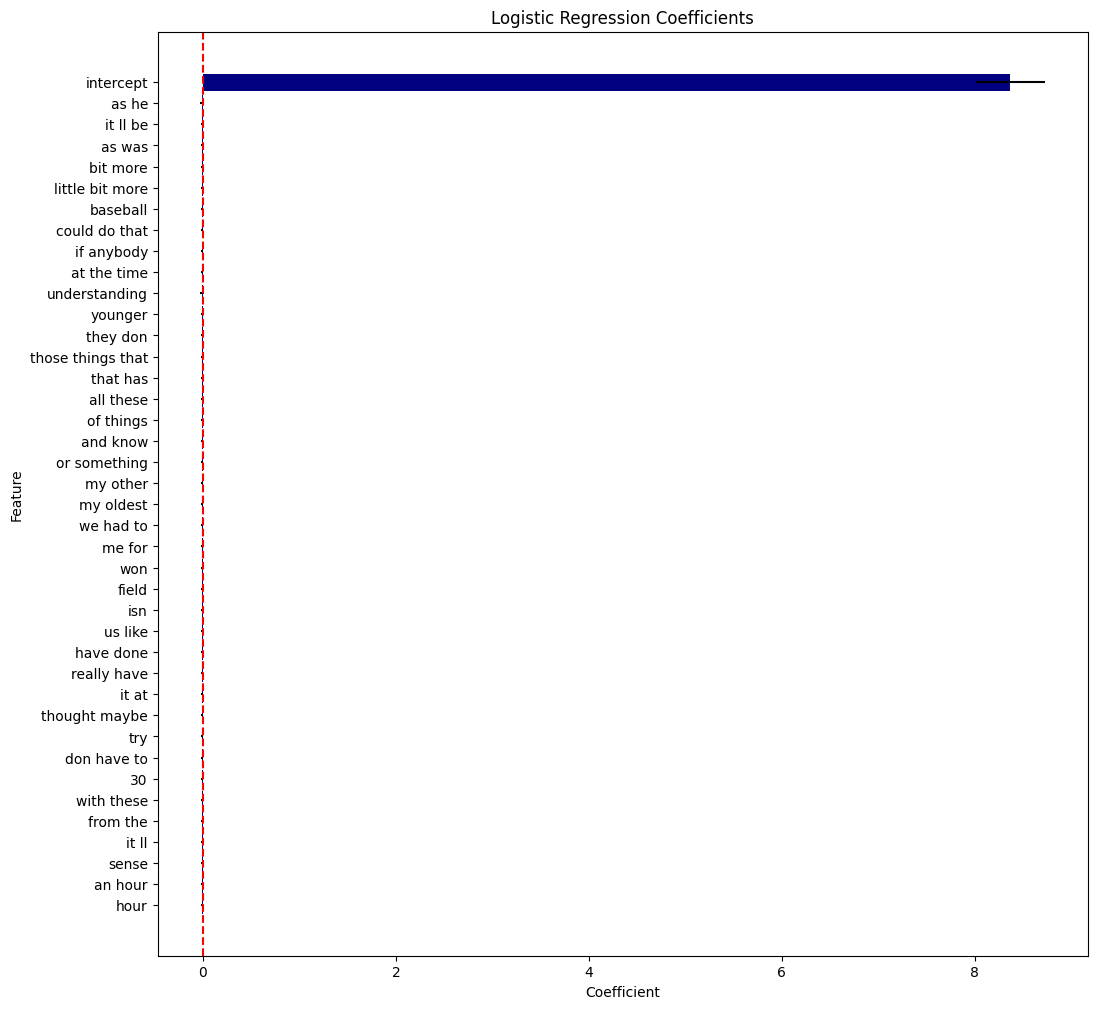

In [54]:
plot_coefs(
    clfs, count_vectorizer.get_feature_names_out(), top_n=40, x_size=12, y_size=12
)